<a href="https://colab.research.google.com/github/widiarsaf/Final_project_pcvk/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_path = '/content/drive/MyDrive/KULIAH/PCVK/final_project/train'
test_path = '/content/drive/MyDrive/KULIAH/PCVK/final_project/train'


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import math
import warnings
warnings.filterwarnings("ignore")
import tensorflow
from tensorflow.keras import optimizers


In [ ]:
!pip install --upgrade tensorflow



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.1 kB/s 
     |████████████████████████████████| 438 kB 58.4 MB/s 
     |████████████████████████████████| 5.8 MB 40.8 MB/s 
     |████████████████████████████████| 1.6 MB 44.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully un

In [5]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model,load_model
conv_base =  InceptionV3(weights='imagenet',include_top=False,
                         input_shape=(300, 300, 3))
output = conv_base.layers[-1].output
output = keras.layers.Flatten()(output)
model_tl = Model(conv_base.input, output)
model_tl.trainable = False
for layer in model_tl.layers:
    layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in  
               model_tl.layers]
model_layers=pd.DataFrame(layers, columns=['Layer Type', 'Layer  Name', 'Layer Trainable'])
print(model_layers) 

                                            Layer Type          Layer  Name  \
0    <keras.engine.input_layer.InputLayer object at...              input_1   
1    <keras.layers.convolutional.conv2d.Conv2D obje...               conv2d   
2    <keras.layers.normalization.batch_normalizatio...  batch_normalization   
3    <keras.layers.core.activation.Activation objec...           activation   
4    <keras.layers.convolutional.conv2d.Conv2D obje...             conv2d_1   
..                                                 ...                  ...   
307  <keras.layers.merging.concatenate.Concatenate ...             mixed9_1   
308  <keras.layers.merging.concatenate.Concatenate ...        concatenate_1   
309  <keras.layers.core.activation.Activation objec...        activation_93   
310  <keras.layers.merging.concatenate.Concatenate ...              mixed10   
311  <keras.layers.reshaping.flatten.Flatten object...              flatten   

     Layer Trainable  
0              False  
1    

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
test_size=12
batch_size=4
epochs=25
train_path='/content/drive/MyDrive/KULIAH/PCVK/final_project/train'
test_path='/content/drive/MyDrive/KULIAH/PCVK/final_project/test'
target_size=(300,300) #resize all images to 300x300
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,  
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range = [0.8, 1.2],
                                   fill_mode='nearest',        
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
                  train_path,
                  target_size=target_size,#  
                  batch_size=batch_size,
                  class_mode='categorical',
                  subset='training')
validation_generator = train_datagen.flow_from_directory(
                       train_path,
                       target_size=target_size,
                       batch_size=batch_size,
                       class_mode='categorical',
                       subset='validation')

Found 30 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras import optimizers
# building a linear stack of layers with the sequential model
model =Sequential()
model.add(model_tl)
# hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(3, activation='softmax'))
# compiling the sequential model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 131072)            21802784  
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 38,580,515
Trainable params: 16,777,731
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [15]:
from keras.callbacks import *
filepath="/content/drive/MyDrive/KULIAH/PCVK/final_project/MyCNN/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1,
                             save_best_only=False,
                             save_freq='epoch',     
                             mode='max')
callbacks_list = [checkpoint]

In [16]:
history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.samples//batch_size,    
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - ETA: 0s - loss: 12.2977 - acc: 0.4615WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0c90304d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach

In [18]:
# Model evaluation
scores_train = model.evaluate(train_generator,verbose=1)
scores_validation = model.evaluate(validation_generator,verbose=1)
print("Train Accuracy: %.2f%%" % (scores_train[1]*100))
print("Validation Accuracy: %.2f%%" % (scores_validation[1]*100))
#For plotting Accuracy and Loss
def LearningCurve(history):
# summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  LearningCurve(history)
#Save the trained model to a file 
model_weight_file='/content/drive/MyDrive/KULIAH/PCVK/final_project/MyCNN/leaf_img.h5'
model.save(model_weight_file)

2/2 [==============================] - 2s 487ms/step - loss: 0.3349 - acc: 0.8333
Train Accuracy: 96.67%
Validation Accuracy: 83.33%


Found 12 images belonging to 3 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 5s 1s/step
[[4 0 0]
 [0 3 1]
 [0 0 4]]
                        precision    recall  f1-score   support

    Cornus_Controversa       1.00      1.00      1.00         4
Eucalyptus_Glaucescens       1.00      0.75      0.86         4
       Fagus_Sylvatica       0.80      1.00      0.89         4

  

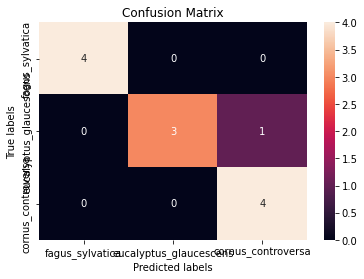

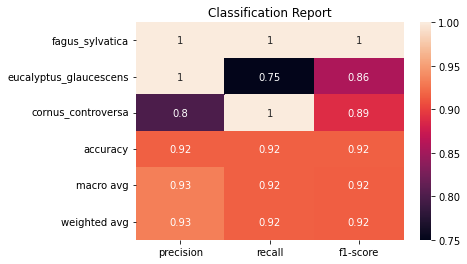

In [19]:
# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
test_steps = compute_steps_per_epoch(test_size)
test_generator = test_datagen.flow_from_directory(
                 test_path,
                 target_size=target_size, 
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
test_generator.reset()
#Calling the saved model for making predictions
tl_img_aug_cnn = load_model(model_weight_file)
pred=tl_img_aug_cnn.predict(test_generator,
                            verbose=1,
                            steps=test_steps)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#create a function for visualizing model performance
import seaborn as sns
def PerformanceReports(conf_matrix,class_report,labels):
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T,  
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
labels=['fagus_sylvatica','eucalyptus_glaucescens','cornus_controversa']
test_labels = [fn.split('/')[0] for fn in filenames]
cm=confusion_matrix(test_labels,predictions)
print(cm)
cr=classification_report(test_labels, predictions)
class_report=classification_report(test_labels, predictions,
                                   target_names=labels,
                                   output_dict=True)
print(cr)
PerformanceReports(cm,class_report,labels)

In [20]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [21]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})